In [26]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import lr_scheduler, SGD
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data preparation (Kaggle dataset)

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in the location `~/.kaggle/kaggle.json`

For protection, remember to modify read-write access to the file:

```chmod 600 ~/.kaggle/kaggle.json```

In [27]:
# In case the Kaggle CLI isn't installed already

# !pip install kaggle > /dev/null

In [32]:
# Specify the location of the dataset for the CLI
# dansbecker/hot-dog-not-hot-dog
DATASET_OWNER = "thedatasith"
DATASET_DIR   = "datasets"
DATASET_NAME  = "hymenoptera"
!mkdir -p "$DATASET_DIR"
!kaggle datasets download "$DATASET_OWNER"/"$DATASET_NAME" -p "$DATASET_DIR"
!unzip -o "$DATASET_DIR"/"$DATASET_NAME".zip -d "$DATASET_DIR"
!rm "$DATASET_DIR"/"$DATASET_NAME".zip

 99%|█████████████████████████████████████▍| 45.0M/45.6M [00:01<00:00, 43.4MB/s]
100%|██████████████████████████████████████| 45.6M/45.6M [00:01<00:00, 31.3MB/s]
Archive:  datasets/hymenoptera.zip
  inflating: datasets/hymenoptera/cover.jpg  
  inflating: datasets/hymenoptera/train/ants/0013035.jpg  
  inflating: datasets/hymenoptera/train/ants/1030023514_aad5c608f9.jpg  
  inflating: datasets/hymenoptera/train/ants/1095476100_3906d8afde.jpg  
  inflating: datasets/hymenoptera/train/ants/1099452230_d1949d3250.jpg  
  inflating: datasets/hymenoptera/train/ants/116570827_e9c126745d.jpg  
  inflating: datasets/hymenoptera/train/ants/1225872729_6f0856588f.jpg  
  inflating: datasets/hymenoptera/train/ants/1262877379_64fcada201.jpg  
  inflating: datasets/hymenoptera/train/ants/1269756697_0bce92cdab.jpg  
  inflating: datasets/hymenoptera/train/ants/1286984635_5119e80de1.jpg  
  inflating: datasets/hymenoptera/train/ants/132478121_2a430adea2.jpg  
  inflating: datasets/hymenoptera/train/ant

In [33]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
                                ]),
    'val':   transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
                                ]),
}

In [34]:
# import data
data_dir = 'datasets/hymenoptera'
sets = ['train', 'val']

datasets = {
            x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                    transform=data_transforms[x]) 
                                    for x in sets
           }

In [35]:
classes = datasets['train'].classes
sizes = {x: len(datasets[x]) for x in sets}
classes

['ants', 'bees']

In [36]:
# define hyper parameters
num_classes   = len( classes )
num_epochs    = 10
batch_size    = 4
learning_rate = 0.001

In [37]:
dataloaders = {
               x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
                             for x in sets
              }

In [38]:
examples = iter(dataloaders['train'])
samples, labels = examples.next()

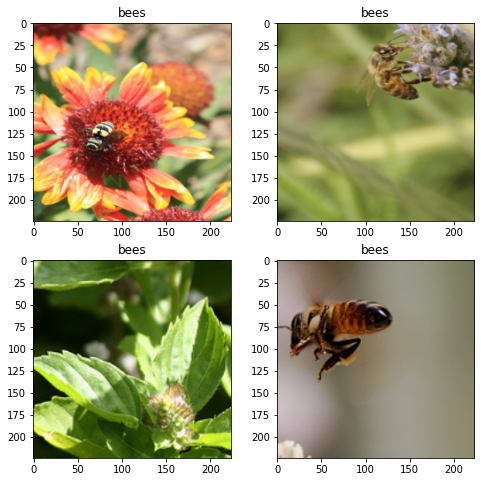

In [39]:
plt.figure(figsize=(8,8))
for i in range(batch_size):
    plt.subplot(2,2,i+1)
    img = samples[i].numpy().transpose((1, 2, 0))
    img = img*std + mean # de-normalize
    plt.imshow(img)
    plt.title(classes[ labels[i] ])
plt.show()

In [40]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred_val, pred_idx = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred_idx == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sizes[phase]
            epoch_accuracy = running_corrects.double() / sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_accuracy:.4f}')

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [41]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_features, len(class_names)).
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6504 Acc: 0.6434
val Loss: 0.4484 Acc: 0.8562

Epoch 2/25
----------
train Loss: 0.4838 Acc: 0.7828
val Loss: 0.3304 Acc: 0.9085

Epoch 3/25
----------
train Loss: 0.4820 Acc: 0.7541
val Loss: 0.2827 Acc: 0.9150

Epoch 4/25
----------
train Loss: 0.4548 Acc: 0.7828
val Loss: 0.2679 Acc: 0.9020

Epoch 5/25
----------
train Loss: 0.4483 Acc: 0.7910
val Loss: 0.2628 Acc: 0.9150

Epoch 6/25
----------
train Loss: 0.3650 Acc: 0.8320
val Loss: 0.2203 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.3844 Acc: 0.8443
val Loss: 0.2336 Acc: 0.9150

Epoch 8/25
----------
train Loss: 0.3556 Acc: 0.8689
val Loss: 0.2105 Acc: 0.9412

Epoch 9/25
----------
train Loss: 0.3778 Acc: 0.8115
val Loss: 0.1964 Acc: 0.9281

Epoch 10/25
----------
train Loss: 0.3411 Acc: 0.8811
val Loss: 0.2160 Acc: 0.9412

Epoch 11/25
----------
train Loss: 0.4058 Acc: 0.8525
val Loss: 0.2097 Acc: 0.9477

Epoch 12/25
----------
train Loss: 0.3481 Acc: 0.8402
val Loss: 0.2058 Acc: 0.9412

E

In [45]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
for param in model_conv.fc.parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6129 Acc: 0.6557
val Loss: 0.4226 Acc: 0.8497

Epoch 2/25
----------
train Loss: 0.4458 Acc: 0.7951
val Loss: 0.2425 Acc: 0.9216

Epoch 3/25
----------
train Loss: 0.3936 Acc: 0.8197
val Loss: 0.2079 Acc: 0.9412

Epoch 4/25
----------
train Loss: 0.4150 Acc: 0.8402
val Loss: 0.2009 Acc: 0.9412

Epoch 5/25
----------
train Loss: 0.5285 Acc: 0.7623
val Loss: 0.2282 Acc: 0.9281

Epoch 6/25
----------
train Loss: 0.3921 Acc: 0.8525
val Loss: 0.1857 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.5622 Acc: 0.7705
val Loss: 0.2562 Acc: 0.9216

Epoch 8/25
----------
train Loss: 0.3779 Acc: 0.8361
val Loss: 0.2002 Acc: 0.9346

Epoch 9/25
----------
train Loss: 0.3225 Acc: 0.8648
val Loss: 0.2258 Acc: 0.9412

Epoch 10/25
----------


KeyboardInterrupt: 